In [1]:
import copy
import random
import re

import numpy
import pandas


from hilbert.curves import Polynomial, Xlog, Log, InverseXPolynomial

from curve_fits import Call, Spec

from curve_fits import fits
from curve_fits import frames

In [2]:
def random_ints_sample(size, max_abs=10000):
    return random.sample(range(-max_abs, max_abs), k=size)

In [3]:
size_range = range(1050, 1750)
overfit = 1  # HIGH to differentiate from single-line shape
init_calls = [Call(random_ints_sample(size)) for size in size_range]
profile = frames.TimeComplexityProfile('set', init_calls, {'pop': Call(), 'copy': Call()},
    index=pandas.Index(size_range, name='List length'), overfit=overfit, fraction=0.9, loops=100)

In [4]:
profile.fit_all_with(
    Call(Spec(Polynomial, 2), Spec(Log, 1, pole=10), initial_params=[-1, 1, -1]),
    Call(Spec(Xlog, 1), Spec(InverseXPolynomial, 1)), piecewise=[
        Call([x], *[Call(Spec(Polynomial, 2))]*2) for x in range(1300, 1420)])

In [5]:
profile.best_fits(limit=3)

kind  \
key  cost                                
pop  0.007157  PW:Poly(1)[1364]Poly(1)   
     0.007223  PW:Poly(1)[1365]Poly(1)   
     0.008029  PW:Poly(1)[1363]Poly(1)   
copy 0.014541  PW:Poly(1)[1364]Poly(1)   
     0.014608  PW:Poly(1)[1367]Poly(1)   
     0.014856  PW:Poly(1)[1365]Poly(1)   

                                                             fit DOF  
key  cost                                                             
pop  0.007157  (-0.0087 ± 0.0024) + (0.0000509 ± 0.0000020)x ...   4  
     0.007223  (-0.0104 ± 0.0025) + (0.0000524 ± 0.0000020)x ...   4  
     0.008029  (-0.0079 ± 0.0027) + (0.0000503 ± 0.0000023)x ...   4  
copy 0.014541  (0.0080 ± 0.0053) + (0.0000625 ± 0.0000044)x |...   4  
     0.014608  (0.0077 ± 0.0054) + (0.0000625 ± 0.0000045)x |...   4  
     0.014856  (0.0117 ± 0.0056) + (0.0000594 ± 0.0000047)x |...   4

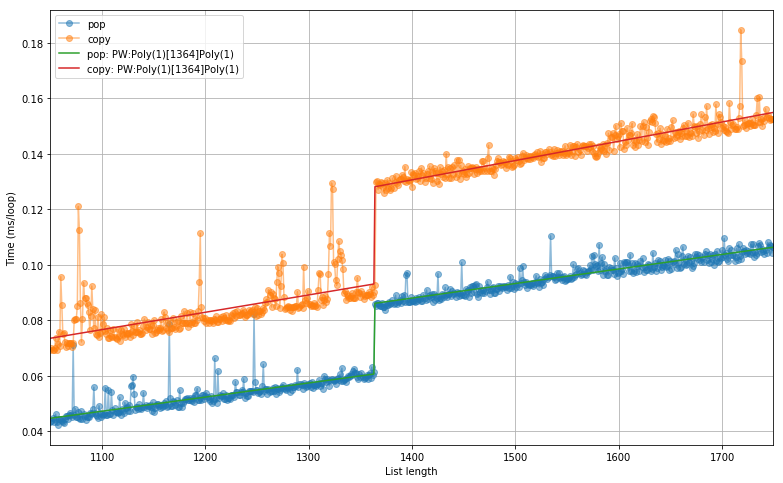

In [6]:
fig, ax = profile.plot(limit=1)

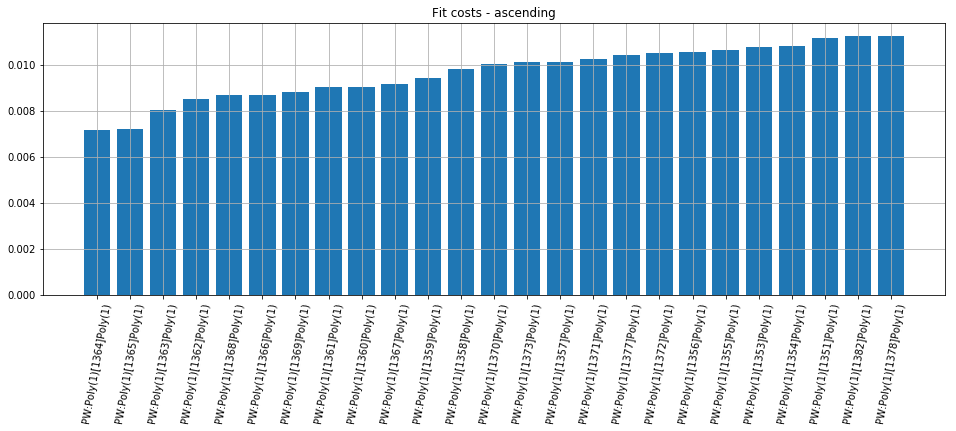

In [7]:
fig, ax = profile.plot_costs('pop', limit=25, rotation=80)

In [8]:
all_fits = profile.best_fits(limit=None)
all_fits[(all_fits.kind == 'Log+Poly(1)') | (all_fits.kind == 'Poly(-1)+Xlog')]

kind  \
key  cost                      
pop  0.018546    Log+Poly(1)   
     0.018897  Poly(-1)+Xlog   
copy 0.027794    Log+Poly(1)   
     0.027907  Poly(-1)+Xlog   

                                                             fit DOF  
key  cost                                                             
pop  0.018546  (-0.59 ± 0.18) + (0.000044 ± 0.000021)x + (0.0...   3  
     0.018897      (0.000010293 ± 8.8E-8)xlogx + (-38.1 ± 1.2)/x   2  
copy 0.027794  (-0.67 ± 0.26) + (0.000070 ± 0.000030)x + (0.0...   3  
     0.027907       (0.00001437 ± 1.3E-7)xlogx + (-41.6 ± 1.8)/x   2

In [9]:
pop_fit = profile.best_fit('pop')
pop_fit, pop_fit.curve

(<PiecewiseFit: (-0.0087 ± 0.0024) + (0.0000509 ± 0.0000020)x | (0.0146 ± 0.0016) + (0.0000524 ± 0.0000010)x>,
 <Vector: (-0.00870578967410196) + (5.0895855178906855e-05)x | (0.014640000646604681) + (5.243870058860575e-05)x>)

In [10]:
pop_fit.fits, pop_fit.jumps_at

((<CurveFit: (-0.0087 ± 0.0024) + (0.0000509 ± 0.0000020)x>,
  <CurveFit: (0.0146 ± 0.0016) + (0.0000524 ± 0.0000010)x>),
 (1364,))

In [11]:
pop_fit.fits[1].measures

(<Measure: 0.0146 ± 0.0016>, <Measure: 0.0000524 ± 0.0000010>)

In [12]:
pop_fit_copy = copy.deepcopy(pop_fit)
pop_fit_copy.series = None   # Mocked to show equality is not affected
assert pop_fit == copy.deepcopy(pop_fit)

In [17]:
pop_fit_call = Call(pop_fit.jumps_at, *[Call(Spec(Polynomial, 2))]*2)
assert pop_fit != fits.PiecewiseFit(profile.data['pop'], pop_fit.space, *pop_fit_call.args, **pop_fit_call.kwargs)

In [16]:
assert [re.sub(r'\[[0-9]{3,}\]', '', kind) for kind in profile.best_fits(limit=1)['kind']] == [
    'PW:Poly(1)Poly(1)', 'PW:Poly(1)Poly(1)']